In [57]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [58]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [59]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/itemreads.pkl','rb'))

## Dataset and DataLoader

In [60]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX[idx].todense().getA1()),torch.FloatTensor(self.dfXv[idx].todense().getA1())

In [61]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [62]:
df_train.shape

(3707, 6041)

In [63]:
bs=32

In [64]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [65]:
df['rating'].min(),df['rating'].max()

(1, 5)

In [66]:
df_train.min(),df_train.max()

(0, 5)

In [67]:
df_train.shape

(3707, 6041)

In [68]:
len(dltrain)

116

## Create the Model Architecture for the Encoder

In [69]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [70]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [71]:
n_item_final=25

In [72]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0.3,0.3,0])

In [73]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6041, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.3)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=25, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.3)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.3)
    )
  )
  (fc): Linear(in_features=100, out_features=6041, bias=True)
  (criterion): MSELoss()
)

In [74]:
for Xb, Xb_v in dltrain:
    print (Xb)
    break

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [75]:
Xb.size()

torch.Size([32, 6041])

In [76]:
Xb.squeeze(0)

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [77]:
preds,loss,preds_train=autoenc.forward(Xb)

In [78]:
loss.backward()

In [79]:
preds.size()

torch.Size([32, 6041])

In [80]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [81]:
device="cuda:0"

In [82]:
wd=1e-7
#wd=1e-1

In [83]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [84]:
len(dltrain)

116

In [85]:
import matplotlib.pyplot as plt

In [86]:
dltrain.batch_size

32

In [87]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [40]:
if 1==0:
    del autoenc
    torch.cuda.empty_cache()

In [41]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0.2,0.2,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [42]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6041, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=25, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
  )
  (fc): Linear(in_features=100, out_features=6041, bias=True)
  (criterion): MSELoss()
)

In [43]:
len(dltrain)

116

In [44]:
learner.lr_find(1e-3,3e-1,dltrain,len(dltrain))

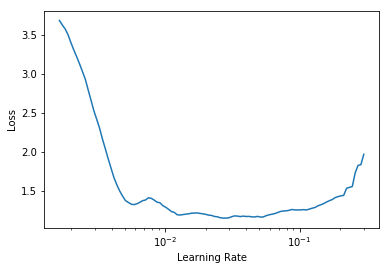

In [45]:
learner.plot_lrs(10)

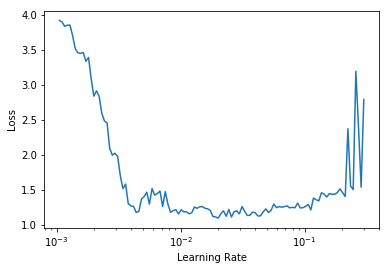

In [46]:
learner.plot_lrs(1)

In [92]:
wd=1e-7
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0.2,0.2,0]).to(device)
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)

In [93]:
learner.run_epochs(dltrain,None,25)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.2927426099777222  Valid Loss:1.2978930473327637 
Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.061172366142273  Valid Loss:1.0642611980438232 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.0144246816635132  Valid Loss:1.0235400199890137 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9958715438842773  Valid Loss:1.0017958879470825 
Epoch:4 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9872220158576965  Valid Loss:0.9985049366950989 
Epoch:5 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9796013236045837  Valid Loss:0.9951202273368835 
Epoch:6 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9765263795852661  Valid Loss:0.9930204153060913 
Epoch:7 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9796016216278076  Valid Loss:0.9975137710571289 
Epoch:8 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9730854630470276  Valid Loss:0.99033123254776 
Epoch:9 Learning rate 

In [94]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=7e-3,end_lr=3e-4)

In [95]:
learner.run_epochs(dltrain,None,31)

Epoch:0 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.95074063539505  Valid Loss:0.9732149243354797 
Epoch:1 Learning rate 0.001449137674618944 Weight Decay 1e-07 Train Loss:0.9226609468460083  Valid Loss:0.9540505409240723 
Epoch:2 Learning rate 0.0003 Weight Decay 1e-07 Train Loss:0.9073414206504822  Valid Loss:0.9614003300666809 
Epoch:3 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9524834752082825  Valid Loss:0.9771212935447693 
Epoch:4 Learning rate 0.0031849589828336264 Weight Decay 1e-07 Train Loss:0.9333845973014832  Valid Loss:0.9657083749771118 
Epoch:5 Learning rate 0.001449137674618944 Weight Decay 1e-07 Train Loss:0.9218928813934326  Valid Loss:0.9599263668060303 
Epoch:6 Learning rate 0.0006593491505914625 Weight Decay 1e-07 Train Loss:0.9112123847007751  Valid Loss:0.9547765254974365 
Epoch:7 Learning rate 0.0003 Weight Decay 1e-07 Train Loss:0.906211256980896  Valid Loss:0.9533622860908508 
Epoch:8 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9499289

In [96]:
torch.save(autoenc,f=f'{DATAPATH}/inter/item_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/item_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/item_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/item_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/item_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [97]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [98]:
item_mtx_1_weights.shape, item_mtx_2_weights.shape

((100, 6041), (25, 100))

In [99]:
df_train.shape

(3707, 6041)

In [100]:
from scipy.special import expit

df_train_item_autoenc=np.tanh(expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T)
df_valid_item_autoenc=np.tanh(expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T)

In [101]:
df_train_item_autoenc=expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T
df_valid_item_autoenc=expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T

In [102]:
df_train_item_autoenc.shape

(3707, 25)

In [103]:
df_valid_item_autoenc.shape

(3707, 25)

In [104]:
df_train_item_autoenc=pd.DataFrame(df_train_item_autoenc)
df_valid_item_autoenc=pd.DataFrame(df_valid_item_autoenc)

In [105]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([100, 6041])

In [106]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([25, 100])

In [107]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [108]:
df_train_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_train_item_autoenc.shape[1])]

In [109]:
df_valid_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_valid_item_autoenc.shape[1])]

In [110]:
df_train_item_autoenc.reset_index(inplace=True)

In [111]:
df_valid_item_autoenc.reset_index(inplace=True)

In [112]:
df_train_item_autoenc.rename({'index':'item_idx'},axis=1,inplace=True)
df_valid_item_autoenc.rename({'index':'item_idx'},axis=1,inplace=True)

In [113]:
import pickle
pickle.dump([df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights],open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','wb'))